In [3]:
!kaggle datasets download -d arkhoshghalb/twitter-sentiment-analysis-hatred-speech

  0% 0.00/1.89M [00:00<?, ?B/s]
100% 1.89M/1.89M [00:00<00:00, 201MB/s]


In [4]:
!unzip /content/twitter-sentiment-analysis-hatred-speech.zip

Archive:  /content/twitter-sentiment-analysis-hatred-speech.zip
  inflating: test.csv                
  inflating: train.csv               


In [2]:
!cp kaggle.json ~/.kaggle

In [182]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [224]:
df = pd.read_csv('train.csv')
display(df.head(), df.shape)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


(31962, 3)

In [225]:
df['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [226]:
df.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [227]:
from string import punctuation
from stop_words import get_stop_words
from nltk import WordNetLemmatizer
import nltk
import re

In [228]:
sw = set(get_stop_words("en"))
puncts = set(punctuation)

In [229]:
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [230]:
morpher = WordNetLemmatizer()


def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = [morpher.lemmatize(word) for word in txt.split() if word not in sw]
    return " ".join(txt)

In [231]:
df['tweet'] = df['tweet'].apply(preprocess_text)

In [232]:
df['tweet'].iloc[:3]

0    user father dysfunctional selfish drag kid dys...
1    user user thanks lyft credit cant use cause do...
2                                       bihday majesty
Name: tweet, dtype: object

In [233]:
train_corpus = " ".join(df["tweet"])
train_corpus = train_corpus.lower()

In [234]:
df_train, df_val = train_test_split(df, random_state=8, stratify= df['label'])

In [235]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)
tokens[:8]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['user',
 'father',
 'dysfunctional',
 'selfish',
 'drag',
 'kid',
 'dysfunction',
 'run']

In [236]:
len(tokens)

286166

In [237]:
tokens_filtered = [word for word in tokens if word.isalnum()]
len(tokens_filtered)

269323

In [238]:
max_words = 1000
max_len = 10
batch_size = 32
epochs = 10

In [239]:
from nltk.probability import FreqDist

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

999

In [240]:
tokens_filtered_top[:5]

['user', 'love', 'day', 'happy', 'u']

In [241]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}


In [242]:
import numpy as np


def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [243]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]])
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["tweet"]])

CPU times: user 2.82 s, sys: 9.98 ms, total: 2.83 s
Wall time: 2.85 s


In [244]:
x_train[:5]

array([[  1,   1,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 93, 793, 744,   0,   0,   0,   0,   0,   0,   0],
       [305, 787, 111,  96, 435, 368,   0,   0,   0,   0],
       [  1,   7,  32, 683,   0,   0,   0,   0,   0,   0],
       [244, 854,   2, 147,   0,   0,   0,   0,   0,   0]])

In [245]:
x_train.shape, x_val.shape

((23971, 10), (7991, 10))

In [246]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [247]:
class LSTMFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)
       
        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        # print(out.shape)
        return torch.sigmoid(out)

In [248]:
from torch.utils.data import DataLoader, Dataset


class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [249]:
lstm_init = LSTMFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(lstm_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [250]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [251]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([32, 10])
torch.Size([32])
tensor(0)


In [252]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [253]:
print(lstm_init)
print("Parameters:", sum([param.nelement() for param in lstm_init.parameters()]))

LSTMFixedLen(
  (embeddings): Embedding(1000, 128, padding_idx=0)
  (lstm): LSTM(128, 20, num_layers=2, batch_first=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 143381


In [254]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [255]:
from torchmetrics import F1Score

In [256]:
f1 = F1Score().to(device)

In [257]:
lstm_init = lstm_init.to(device)
lstm_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    lstm_init.train()
    running_items, running_right, f1_train = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = lstm_init(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        f1_train += f1(outputs, labels)
        
    # выводим статистику о процессе обучения
    lstm_init.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            # f'Acc: {running_right / running_items:.3f}',
            f'F1: {f1_train / len(train_loader):.3f}',
            end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    f1_train = 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    f1_test = 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = lstm_init(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
        f1_test += f1(test_outputs, test_labels)
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. F1_score: {f1_test / len(val_loader):.3f}')
        
print('Training is finished!')

Epoch [1/10]. Step [750/750]. Loss: 0.685. F1: 0.156. Test loss: 0.023. F1_score: 0.158
Epoch [2/10]. Step [750/750]. Loss: 0.037. F1: 0.383. Test loss: 0.266. F1_score: 0.174
Epoch [3/10]. Step [750/750]. Loss: 0.189. F1: 0.450. Test loss: 0.039. F1_score: 0.185
Epoch [4/10]. Step [750/750]. Loss: 0.120. F1: 0.471. Test loss: 0.033. F1_score: 0.195
Epoch [5/10]. Step [750/750]. Loss: 0.003. F1: 0.496. Test loss: 0.352. F1_score: 0.211
Epoch [6/10]. Step [750/750]. Loss: 0.002. F1: 0.496. Test loss: 0.128. F1_score: 0.221
Epoch [7/10]. Step [750/750]. Loss: 0.063. F1: 0.559. Test loss: 0.012. F1_score: 0.203
Epoch [8/10]. Step [750/750]. Loss: 0.003. F1: 0.545. Test loss: 0.047. F1_score: 0.213
Epoch [9/10]. Step [750/750]. Loss: 0.001. F1: 0.583. Test loss: 0.063. F1_score: 0.223
Epoch [10/10]. Step [750/750]. Loss: 0.030. F1: 0.593. Test loss: 0.046. F1_score: 0.217
Training is finished!


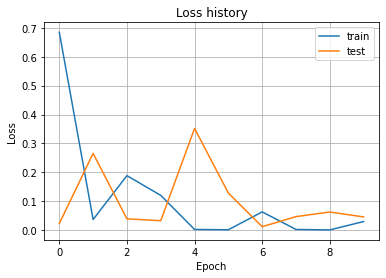

In [258]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

In [259]:
class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True, )
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)
       
        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        return torch.sigmoid(out)

In [260]:
gru_init = GRUFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(gru_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [261]:
print(gru_init)
print("Parameters:", sum([param.nelement() for param in gru_init.parameters()]))

GRUFixedLen(
  (embeddings): Embedding(1000, 128, padding_idx=0)
  (gru): GRU(128, 20, num_layers=2, batch_first=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 139541


In [262]:
gru_init = gru_init.to(device)
gru_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    gru_init.train()
    running_items, running_right, f1_train = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = gru_init(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        f1_train += f1(outputs, labels)
        
    # выводим статистику о процессе обучения
    gru_init.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            # f'Acc: {running_right / running_items:.3f}',
            f'F1: {f1_train / len(train_loader):.3f}',
            end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    f1_train = 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    f1_test = 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = gru_init(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
        f1_test += f1(test_outputs, test_labels)
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. F1_score: {f1_test / len(val_loader):.3f}')
        
print('Training is finished!')

Epoch [1/10]. Step [750/750]. Loss: 0.027. F1: 0.201. Test loss: 0.031. F1_score: 0.157
Epoch [2/10]. Step [750/750]. Loss: 0.014. F1: 0.386. Test loss: 0.074. F1_score: 0.189
Epoch [3/10]. Step [750/750]. Loss: 0.120. F1: 0.418. Test loss: 0.091. F1_score: 0.190
Epoch [4/10]. Step [750/750]. Loss: 0.396. F1: 0.438. Test loss: 0.067. F1_score: 0.204
Epoch [5/10]. Step [750/750]. Loss: 0.039. F1: 0.466. Test loss: 0.033. F1_score: 0.188
Epoch [6/10]. Step [750/750]. Loss: 0.069. F1: 0.509. Test loss: 0.494. F1_score: 0.211
Epoch [7/10]. Step [750/750]. Loss: 0.002. F1: 0.505. Test loss: 0.228. F1_score: 0.206
Epoch [8/10]. Step [750/750]. Loss: 0.002. F1: 0.517. Test loss: 0.331. F1_score: 0.215
Epoch [9/10]. Step [750/750]. Loss: 0.042. F1: 0.542. Test loss: 0.078. F1_score: 0.220
Epoch [10/10]. Step [750/750]. Loss: 0.515. F1: 0.544. Test loss: 0.522. F1_score: 0.217
Training is finished!


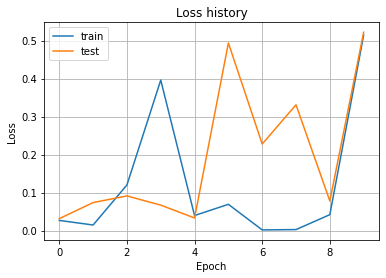

In [263]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();